# Twin4Build: Building Space Example

This notebook demonstrates how to create and simulate a detailed building space model using Twin4Build. You'll learn how to:
1. Create a building space with thermal and CO2 parameters
2. Set up various schedules (occupancy, temperature, solar radiation)
3. Connect components and create a complete building model
4. Simulate and analyze the building's thermal and CO2 performance

This example is particularly useful for understanding how different factors affect building performance, including:
- Thermal mass and insulation effects
- Occupancy patterns and CO2 levels
- Solar radiation impact
- Ventilation and heating control

## 1. Setup
First, let's install and import the necessary packages. If you're running this in Google Colab, uncomment the pip install line.

In [1]:
# %pip install git+https://github.com/JBjoernskov/Twin4Build.git # Uncomment in google colab
import sys
sys.path.append(r"C:\Users\jabj\Documents\python\Twin4Build")
import twin4build as tb
import datetime
from dateutil import tz
import matplotlib.pyplot as plt
import numpy as np

## 2. Create the Model

Let's create a new model instance. This will be our container for all the building components.

In [2]:
# Create a new model
model = tb.Model(id="building_space_example")
print(model)

+------------------------------------------------------------------------------------------------------------------------------+
|                                          Model overview    id: building_space_model                                          |
+---------------------------------------------+--------------------------------------------------------------------------------+
|  Number of components in simulation model:  |                                       0                                        |
+---------------------------------------------+--------------------------------------------------------------------------------+
| Number of connections in simulation model:  |                                       0                                        |
+---------------------------------------------+--------------------------------------------------------------------------------+
|              Model directory:               | C:\Users\jabj\AppData\Local\Temp\1\generated_file

C:\Users\jabj\Documents\python\Twin4Build\twin4build\utils\mkdir_in_root.py:5: MainPathNotFound: Could not determine main module path, using temp dir: C:\Users\jabj\AppData\Local\Temp\1
  current_dir = get_main_dir()


## 3. Create Building Components

Now we'll create the main building space component with its thermal and CO2 parameters. This component models:
- Thermal mass of air, walls, and interior elements
- Heat transfer through walls and boundaries
- CO2 generation from occupants
- Air infiltration and ventilation

In [3]:
# Create a building space with thermal parameters
# Define parameters for the thermal and mass models
thermal_kwargs = dict(
    C_air=5000000.0,
    C_wall=10000000.0,
    C_int=500000.0,
    C_boundary=800000.0,
    R_out=0.01,
    R_in=0.01,
    R_int=100000,
    R_boundary=10000,
    f_wall=0,
    f_air=0,
    Q_occ_gain=100.0,
    infiltration=0.0,
    airVolume=100.0,
    id="BuildingSpaceThermal"
)
mass_kwargs = dict(
    V=120.0,  # Example: 100 m^3 * 1.2 kg/m^3
    G_occ=5e-6,
    m_inf=0.01/3600,
    id="BuildingSpaceMass"
)
building_space = tb.BuildingSpaceTorchSystem(
    thermal_kwargs=thermal_kwargs,
    mass_kwargs=mass_kwargs,
    id="BuildingSpace"
)
print("Building space component created:")
print(building_space)

Building space component created:
+--------------------------------------------------+
|     Component overview    id: BuildingSpace      |
+-------------------------+------------------------+
|          input          |         output         |
+-------------------------+------------------------+
|    outdoorTemperature   |   indoorTemperature    |
|       airFlowRate       |    wallTemperature     |
|   supplyAirTemperature  | indoorCo2Concentration |
|    globalIrradiation    |                        |
|      numberOfPeople     |                        |
| outdoorCo2Concentration |                        |
|           Q_sh          |                        |
|        T_boundary       |                        |
|  indoorTemperature_adj  |                        |
+-------------------------+------------------------+


## 4. Create Schedules

Now we'll create various schedules to control different aspects of the building:
1. Occupancy schedule - simulates people entering and leaving
2. Outdoor temperature schedule - simulates weather conditions
3. Solar radiation schedule - simulates solar heat gains
4. Air flow schedule - controls ventilation
5. Supply air temperature schedule - controls heating/cooling
6. Outdoor CO2 schedule - simulates outdoor air quality
7. Space heater schedule - controls heating system
8. Boundary temperature schedule - simulates adjacent spaces

In [4]:
# Create a schedule for occupancy
occupancy_schedule = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [8, 9, 10, 12, 14, 16, 18],
        "ruleset_end_hour": [9, 10, 12, 14, 16, 18, 20],
        "ruleset_value": [0, 0, 0, 0, 0, 0, 0]  # Number of occupants
    },
    id="OccupancySchedule"
)

# Create an outdoor temperature profile
outdoor_temp = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 10.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 6, 12, 18, 21, 23, 24],
        "ruleset_end_hour": [6, 12, 18, 21, 23, 24, 24],
        "ruleset_value": [5.0, 8.0, 15.0, 12.0, 8.0, 5.0, 5.0]  # Temperature in °C
    },
    id="OutdoorTemperature"
)

# Create a solar radiation profile
solar_radiation = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 0.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 6, 9, 12, 15, 18, 24],
        "ruleset_end_hour": [6, 9, 12, 15, 18, 24, 24],
        "ruleset_value": [0.0, 100, 300, 300, 100, 0.0, 0.0]  # Solar radiation in W/m²
    },
    id="SolarRadiation"
)

# Create an air flow rate schedule
air_flow = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 0.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 8, 16, 0, 0, 0, 0],
        "ruleset_end_hour": [8, 16, 24, 0, 0, 0, 0],
        "ruleset_value": [0, 0, 0, 0.0, 0.0, 0.0, 0.0]  # Air flow rate in m³/s
    },
    id="AirFlow"
)

# Create a supply air temperature schedule
supply_air_temp = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 20.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 8, 16, 0, 0, 0, 0],
        "ruleset_end_hour": [8, 16, 24, 0, 0, 0, 0],
        "ruleset_value": [0, 0, 0, 0.0, 0.0, 0.0, 0.0]  # Temperature in °C
    },
    id="SupplyAirTemperature"
)

# Create an outdoor CO2 concentration schedule
outdoor_co2 = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 400.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 8, 16, 0, 0, 0, 0],
        "ruleset_end_hour": [8, 16, 24, 0, 0, 0, 0],
        "ruleset_value": [0, 0, 0, 0.0, 0.0, 0.0, 0.0]  # CO2 concentration in ppm
    },
    id="OutdoorCO2"
)

# Create a space heater schedule
space_heater = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 0.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 6, 8, 16, 18, 0, 0],
        "ruleset_end_hour": [6, 8, 16, 18, 24, 0, 0],
        "ruleset_value": [0, 300, 500, 0, 0.0, 0.0, 0.0]  # Heat input in W
    },
    id="SpaceHeater"
)

# Create a boundary temperature schedule
boundary_temp = tb.ScheduleSystem(
    weekDayRulesetDict={
        "ruleset_default_value": 20.0,
        "ruleset_start_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_end_minute": [0, 0, 0, 0, 0, 0, 0],
        "ruleset_start_hour": [0, 8, 16, 0, 0, 0, 0],
        "ruleset_end_hour": [8, 16, 24, 0, 0, 0, 0],
        "ruleset_value": [20, 20, 20, 20, 20, 20, 20]  # Temperature in °C
    },
    id="BoundaryTemperature"
)

## 5. Connect Components

Now we'll connect all the components to create our complete building model. Each connection represents a physical or logical relationship between components.

In [5]:
# Connect components
model.add_connection(occupancy_schedule, building_space, "scheduleValue", "numberOfPeople")
model.add_connection(outdoor_temp, building_space, "scheduleValue", "outdoorTemperature")
model.add_connection(solar_radiation, building_space, "scheduleValue", "globalIrradiation")
model.add_connection(air_flow, building_space, "scheduleValue", "supplyAirFlowRate")
model.add_connection(air_flow, building_space, "scheduleValue", "exhaustAirFlowRate")
model.add_connection(supply_air_temp, building_space, "scheduleValue", "supplyAirTemperature")
model.add_connection(outdoor_co2, building_space, "scheduleValue", "outdoorCO2")
model.add_connection(space_heater, building_space, "scheduleValue", "heatGain")
model.add_connection(boundary_temp, building_space, "scheduleValue", "boundaryTemperature")

print("All components connected successfully!")

All components connected successfully!


## 6. Load and Simulate the Model

Now we'll load the model and run a simulation for a 4-day period. We'll use 10-minute time steps for good accuracy.

In [6]:
# Load the model
model.load()
print("Model loaded successfully!")

# Set up simulation parameters
simulator = tb.Simulator()
stepSize = 600  # 10 minutes in seconds
startTime = datetime.datetime(
    year=2024, month=1, day=1, hour=0, minute=0, second=0,
    tzinfo=tz.gettz("Europe/Copenhagen")
)
endTime = datetime.datetime(
    year=2024, month=1, day=5, hour=0, minute=0, second=0,
    tzinfo=tz.gettz("Europe/Copenhagen")
)

# Run simulation
simulator.simulate(
    model,
    stepSize=stepSize,
    startTime=startTime,
    endTime=endTime
)
print("Simulation completed successfully!")


Loading model...[OK]
   |___Drawing simulation model...
Loading model...[OK]
   |___Removing cycles...[OK]
   |___Determining execution order...[OK]
   |___Loading parameters...[OK]
   |___Validating model...[WARNING]
   |   |
   |   |___|CLASS: BuildingSpaceStateSpace|ID: BuildingSpace|: Missing connections for the following input(s) to enable use of Simulator, Estimator, Evaluator, and Monitor:
   |   |   |
   |   |   |___indoorTemperature_adj
   |   |
   |
   |___Validated for Simulator...FAILED
   |___Validated for Estimator...FAILED
   |___Validated for Evaluator...FAILED
   |___Validated for Monitor...FAILED
   |___

+----------------------------------------------------------------------+
|     Model overview    id: building_space_model_simulation_model      |
+--------------------------------------------+-------------------------+
| Number of components in simulation model:  |            9            |
+--------------------------------------------+-------------------------+
|  

100%|██████████| 576/576 [00:00<00:00, 2130.16it/s]

Simulation completed successfully!


## 7. Visualize Results

Let's create plots to visualize the simulation results. We'll show:
1. Indoor and wall temperatures
2. Heating power and solar radiation
3. Outdoor temperature

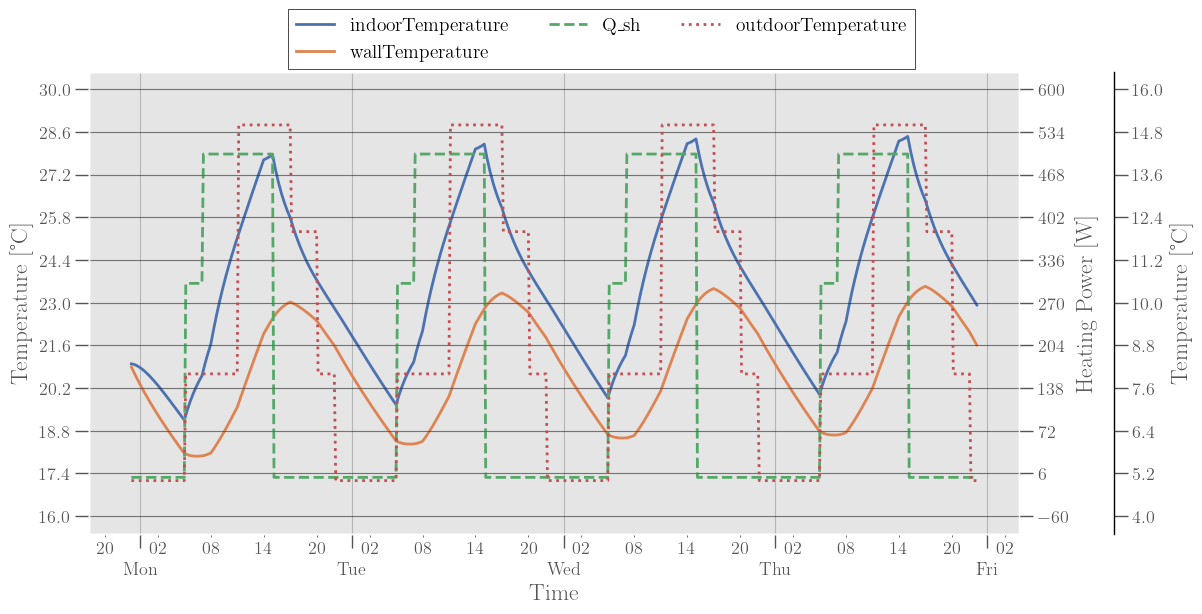

(<Figure size 1200x600 with 3 Axes>,
 [<Axes: xlabel='Time', ylabel='Temperature [°C]'>,
  <Axes: ylabel='Heating Power [W]'>,
  <Axes: ylabel='Temperature [°C]'>])

In [7]:
# Plot results using Twin4Build's plotting utility
tb.plot.plot_component(
    simulator,
    components_1axis=[
        ("BuildingSpace", "indoorTemperature", "output"),
        ("BuildingSpace", "wallTemperature", "output"),
    ],
    components_2axis=[
        ("BuildingSpace", "Q_sh", "input")
    ],
    components_3axis=[
        ("BuildingSpace", "outdoorTemperature", "input"),
    ],
    ylabel_1axis="Temperature [°C]",
    ylabel_2axis="Heating Power [W]",
    ylabel_3axis="Temperature [°C]",
    show=True,
    nticks=11
)

## 8. Conclusion and Next Steps

In this example, we've created a detailed building space model that simulates:
1. Thermal dynamics of the space and its walls
2. CO2 concentration based on occupancy
3. Solar radiation effects
4. Heating system performance

### Key Parameters to Experiment With:
- Thermal mass values (C_air, C_wall, etc.)
- Thermal resistance values (R_out, R_in, etc.)
- Occupancy patterns
- Heating schedules
- Ventilation rates

### Troubleshooting Tips:
1. If temperatures are too high/low:
   - Check heating schedule values
   - Verify thermal resistance values
   - Adjust solar radiation impact

2. If simulation fails to converge:
   - Try reducing the step size
   - Check for unrealistic parameter values
   - Verify all connections are correct

3. If results look unrealistic:
   - Validate all schedule values
   - Check unit conversions
   - Verify thermal mass and resistance values

### Next Steps:
1. Add more complex control strategies
2. Model multiple zones
3. Add weather data integration
4. Implement energy optimization
5. Add more detailed HVAC components